In [1]:
from pprint import pprint
import json
import pandas as pd
import pickle as pkl
import os

In [2]:
testdata = []
for i in range(0,50):
    with open(f'newdata{i}.json', 'r') as open_file:
        testdata.extend(json.load(open_file))

In [3]:
print(len(testdata))

250000


In [4]:
subdata = []
for directory in os.listdir('data'):
    for i in range(2):
        with open(f'data/{directory}/data{i}.json', 'r') as open_file:
            subdata.extend(json.load(open_file))

In [5]:
print(len(subdata))

300000


In [6]:
pprint(testdata[23], indent=1)

{'author': '302w',
 'author_flair_background_color': '',
 'author_flair_css_class': 'nyy',
 'author_flair_richtext': [{'e': 'text', 't': 'New York Yankees'}],
 'author_flair_template_id': None,
 'author_flair_text': 'New York Yankees',
 'author_flair_text_color': 'dark',
 'author_flair_type': 'richtext',
 'body': 'Obviously the culture there is all fucked. Not a good look for '
         're-signing Harper.',
 'created': 1534830598.0,
 'created_utc': 1534805398,
 'id': 'e4jmj9t',
 'link_id': 't3_98wegv',
 'no_follow': True,
 'parent_id': 't3_98wegv',
 'permalink': '/r/baseball/comments/98wegv/nats_gm_kelley_had_nearphysical_altercation/e4jmj9t/',
 'retrieved_on': 1534805399,
 'score': 1,
 'send_replies': True,
 'stickied': False,
 'subreddit': 'baseball',
 'subreddit_id': 't5_2qm7u'}


In [7]:
with open('teams_set.pkl', 'rb') as open_file:
    teams = pkl.load(open_file)

In [8]:
def build_row(comment):
    body = comment['body'].lower()
    author = comment['author']
    team = comment['author_flair_richtext'][0]['t'].lower().strip() if comment['author_flair_text'] else None
    if team == 'cincinnati redlegs':
        team = 'cincinnati reds'
    if team == 'st louis cardinals':
        team = 'st. louis cardinals'
    if team == 'california angels':
        team = 'los angeles angels'
    if team == 'florida marlins':
        team = 'miami marlins'
    elif team == 'san fransico giants' or team == 'san fransisco giants':
        team = 'san francisco giants'
    subreddit = comment['subreddit']
    score = comment['score']
    created_utc = comment['created_utc']
    
    return [body, author, team, subreddit, score, created_utc]

In [9]:
comments = []
for comment in testdata:
    atts = build_row(comment)
    comments.append(atts)

In [10]:
dot = pd.DataFrame(comments, columns=['body', 'author', 'team', 'subreddit', 'score', 'created_utc'])

In [11]:
del comments

In [12]:
del testdata

In [14]:
teams

{'arizona diamondbacks',
 'atlanta braves',
 'baltimore orioles',
 'boston red sox',
 'chicago cubs',
 'chicago white sox',
 'cincinnati reds',
 'cleveland indians',
 'colorado rockies',
 'detroit tigers',
 'houston astros',
 'kansas city royals',
 'los angeles angels',
 'los angeles dodgers',
 'miami marlins',
 'milwaukee brewers',
 'minnesota twins',
 'new york mets',
 'new york yankees',
 'oakland athletics',
 'philadelphia phillies',
 'pittsburgh pirates',
 'san diego padres',
 'san francisco giants',
 'seattle mariners',
 'st. louis cardinals',
 'tampa bay rays',
 'texas rangers',
 'toronto blue jays',
 'washington nationals'}

In [15]:
import re

In [16]:
def filter_quotes(comment_text):
    if re.match('&gt;', comment_text) and not re.search('\n\n', comment_text):
        return ''
    return re.sub(r'&gt;.*?\n\n', '', comment_text)

In [17]:
def discard_removed(df):
    df2 = df[df['body'] != '[removed]'].copy()
    return df2

In [18]:
def discard_non_mlb(df):
    df2 = df[df['team'].isin(teams)].copy()
    return df2

In [19]:
dot = discard_removed(dot)

In [20]:
dot = discard_non_mlb(dot)

In [21]:
dot['body'] = dot.apply(lambda row: filter_quotes(row['body']), axis=1)

In [22]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [23]:
dot = standardize_text(dot, 'body')

In [24]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

dot['tokens'] = dot['body'].apply(tokenizer.tokenize)
dot.head()

,body,author,team,subreddit,score,created_utc,tokens
1,"strikeouts are through the roof, base hits are...",captainbuttercream,chicago cubs,baseball,1,1534805649,"[strikeouts, are, through, the, roof, base, hi..."
2,why do morons type multiple o's as if it makes...,ss_lmtd,new york mets,baseball,1,1534805641,"[why, do, morons, type, multiple, o, s, as, if..."
3,yeah,MimonFishbaum,kansas city royals,baseball,1,1534805638,[yeah]
4,"woah, woah, woah i, asked if you could",heyitsizak,new york yankees,baseball,1,1534805617,"[woah, woah, woah, i, asked, if, you, could]"
6,"he's got 74 9 rwar, he fell off his first ball...",Honk4Tits,detroit tigers,baseball,1,1534805602,"[he, s, got, 74, 9, rwar, he, fell, off, his, ..."


In [25]:
dot = dot.groupby(['author', 'team'])['tokens'].aggregate(sum)

In [26]:
dot = dot.reset_index()

In [27]:
dot.head(5)

,author,team,tokens
0,-300BlackoutDrunk-,arizona diamondbacks,[na]
1,-Basileus,los angeles angels,"[it, s, the, source, of, his, power, writing, ..."
2,-BeefSupreme,st. louis cardinals,"[oh, thank, god, slugging, people, who, enjoy,..."
3,-DangleAngle-,st. louis cardinals,"[hi, fellow, colts, cards, fan, can, you, prov..."
4,-Don-Draper-,new york yankees,"[so, you, guys, are, going, to, trade, him, to..."


In [28]:
dot.set_index('author', inplace=True)

In [29]:
dot = dot[~dot.index.duplicated(keep='first')]

I need to transform comments separrately in subreddit data to add to dot

In [30]:
def build_subreddit_row(comment):
    body = comment['body'].lower()
    author = comment['author']
    
    return [body, author]

In [31]:
comments = []
for comment in subdata:
    atts = build_subreddit_row(comment)
    comments.append(atts)

In [32]:
dolly = pd.DataFrame(comments, columns=['body', 'author'])

In [33]:
del subdata

In [34]:
dolly = discard_removed(dolly)

In [35]:
dolly['body'] = dolly.apply(lambda row: filter_quotes(row['body']), axis=1)

In [36]:
dolly = dolly[dolly['author'] != 'AutoModerator']

In [37]:
dolly = standardize_text(dolly, 'body')

In [38]:
dolly['tokens'] = dolly['body'].apply(tokenizer.tokenize)
dolly.head()

,body,author,tokens
0,"hey now, second half 2017 john lackey wasn't a...",poowrestler,"[hey, now, second, half, 2017, john, lackey, w..."
1,our offense is brutal right now,WorkTomorrow,"[our, offense, is, brutal, right, now]"
2,contreras is a disaster at the plate right now,SamWegner,"[contreras, is, a, disaster, at, the, plate, r..."
3,willson just has some really rough at bats som...,zns26,"[willson, just, has, some, really, rough, at, ..."
4,how do you miss that it was a missed location ...,FreshInstance,"[how, do, you, miss, that, it, was, a, missed,..."


In [39]:
dolly = dolly.groupby('author')['tokens'].aggregate(sum)

In [40]:
dolly = dolly.reset_index()
dolly.set_index('author', inplace=True)

In [41]:
dot_authors=set(dot.index)
for author in dolly.index:
    if author in dot_authors:
        dot.loc[author,'tokens'].extend(dolly.loc[author, 'tokens'])

In [42]:
del dolly

In [43]:
from nltk.stem.wordnet import WordNetLemmatizer

lemm = WordNetLemmatizer()

dot['tokens'] = dot['tokens'].apply(lambda tokens: [lemm.lemmatize(token) for token in tokens])

In [44]:
import nltk
from nltk.corpus import stopwords
s_words = set(stopwords.words('english'))

In [45]:
baseball_stopwords = {'game', 'team', 'baseball', 'player', 'like', 'year', 'one', 'would', 'think', 'good', 'season', 'make', 'even', 'inning', 'guy', 'hit', 'really', 'still',
                     'play', 'got', '1', '2', '3', 'better', 'right', 'see', 'run', 'win', 'pitcher', 'first', 'back', 'know', 'fan', 'go',
                     'people', 'well', 'going', 'say', 'way', 'much', 'ball', 'best', 'thing', 'shit', 'around',
                     'career', 'era', 'anything', 'dude', 'hard', 'hitting', '8', 'new', '9', 'average', 'either', 'definitely',
                     'playing', 'read', 'wa', 'mlb', 'pitching', 'part', 'wrong', 'trying', 'sport', 'fun', 'home',
                     'name', 'work', 'away', 'went', 'reason', 'god', 'number', 'old', 'post', 'week', 'division', 'hate',
                     'record', 'night', 'played', 'already', 'seems', 'anyone', 'nothing', 'tonight', 'get', 'pitch', 'ha',
                     'last', 'could', 'bad', 'day', 'time', 'let', 'though', 'sure', 'probably', 'yeah', 'lol', 'also', '5', '4',
                     'two', 'lot', 'man', 'u'}
s_words = s_words.union(baseball_stopwords)
dot['tokens'] = dot.apply(lambda row: [token for token in row['tokens'] if token not in s_words], axis=1)

In [46]:
dot['token_strings'] = dot['tokens'].apply(lambda x: ' '.join(x))

In [47]:
freq = pd.Series(' '.join(dot['token_strings']).split()).value_counts()

In [48]:
freq

fuck                                       9743
need                                       8566
want                                       8495
look                                       8235
pretty                                     7610
take                                       7536
fucking                                    7286
great                                      7242
mean                                       7011
yankee                                     6860
love                                       6840
never                                      6830
every                                      6687
start                                      6448
something                                  6245
said                                       6131
league                                     6038
trade                                      5951
come                                       5901
getting                                    5802
series                                  

In [49]:
inf_words = set(freq[freq <= 10].keys())

In [50]:
dot['tokens'] = dot.apply(lambda row: [token for token in row['tokens'] if token not in inf_words], axis=1)

In [51]:
dot['token_strings'] = dot['tokens'].apply(lambda x: ' '.join(x))

In [52]:
dot = dot[dot['tokens'].map(len) > 2]

In [53]:
dot = dot[dot['token_strings'] > '']

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [55]:
vect = TfidfVectorizer(strip_accents='unicode', ngram_range=(1, 2))

vectorized_comments = vect.fit_transform(dot['token_strings'])

vectorized_comments

<16387x1455555 sparse matrix of type '<class 'numpy.float64'>'
	with 3827625 stored elements in Compressed Sparse Row format>

In [56]:
dot.reset_index(inplace=True)

In [57]:
labels = dot['team']

In [58]:
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split

In [59]:
from imblearn.under_sampling import RandomUnderSampler

In [60]:
rus = RandomUnderSampler(random_state=10)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(vectorized_comments, labels, random_state=10)

In [62]:
X_train, y_train = rus.fit_sample(X_train, y_train)

In [64]:
from sklearn.dummy import DummyClassifier

In [65]:
dummy = DummyClassifier()

In [67]:
dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [70]:
dummy_pred = dummy.predict(X_test)

In [73]:
accuracy_score(y_test, dummy_pred)

0.03392726385159873

In [74]:
NBmodel = naive_bayes.MultinomialNB()

In [75]:
NBmodel.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [76]:
y_pred = NBmodel.predict(X_test)

In [71]:
from sklearn.metrics import accuracy_score

In [67]:
y_pred_train = NBmodel.predict(X_train)

In [78]:
y_pred_proba = NBmodel.predict_proba(X_test)

In [79]:
from sklearn.metrics import roc_auc_score

In [68]:
accuracy_score(y_train, y_pred_train)

0.9983818770226537

In [77]:
accuracy_score(y_test, y_pred)

0.26946546253356113

In [91]:
len(y_test)

4097

In [81]:
pd.Series(y_test).value_counts()

boston red sox           369
new york yankees         368
chicago cubs             309
atlanta braves           247
toronto blue jays        221
los angeles dodgers      219
san francisco giants     180
new york mets            174
seattle mariners         167
st. louis cardinals      162
philadelphia phillies    141
houston astros           122
cleveland indians        117
washington nationals     116
baltimore orioles        112
milwaukee brewers         97
los angeles angels        97
texas rangers             94
minnesota twins           93
oakland athletics         91
pittsburgh pirates        84
detroit tigers            81
arizona diamondbacks      68
kansas city royals        67
colorado rockies          64
chicago white sox         62
cincinnati reds           58
san diego padres          54
tampa bay rays            39
miami marlins             24
Name: team, dtype: int64

In [82]:
pd.Series(y_pred).value_counts()

chicago white sox        776
san diego padres         441
colorado rockies         300
miami marlins            253
pittsburgh pirates       174
tampa bay rays           164
kansas city royals       163
los angeles angels       154
houston astros           130
washington nationals     117
san francisco giants     112
minnesota twins          103
cincinnati reds           99
cleveland indians         99
baltimore orioles         92
arizona diamondbacks      84
chicago cubs              82
detroit tigers            80
milwaukee brewers         80
oakland athletics         73
seattle mariners          72
philadelphia phillies     68
new york mets             68
texas rangers             61
boston red sox            57
st. louis cardinals       51
atlanta braves            45
new york yankees          44
toronto blue jays         43
los angeles dodgers       12
dtype: int64

In [109]:
bad_indices = y_test[y_test != y_pred].index

In [110]:
bad_indices

Int64Index([ 5180,  5639, 11120,  3906, 14274, 14937,  8466,  7424, 14892,
             2953,
            ...
            15676, 12907, 10378, 13521,  3579, 15997,  4792,   609,  4714,
            15237],
           dtype='int64', length=2993)

In [74]:
for i in bad_indices:
    print(i)
    print(dot.iloc[i,1])
    print(dot.iloc[i,3])

5180
seattle mariners
terrible field effect long major league dh apparently pretty demoralizing since worst unheard refuse become full dhs worst dhs fielder sitting bench turn lineup doe apparently mess ability
5639
new york yankees
replay taught umpire suck sound dated touch italian low health happ turned fucking amazing signing funny doom gloom sub suddenly 32 500 7 streaky watched 50 watched single fucking month painful
11120
chicago cubs
need san fran jabari splash
3906
los angeles dodgers
weird hell kik likely ground double jesus swing saying upset deal frustration major slump hopefully stay short seager moving 2nd due le stress arm hip maeda seriously statistical argument bring dire situation
14274
seattle mariners
cub rizzo favorite class act
14937
chicago cubs
ted williams advocated uppercut swing fyi increase shift hasnt affected babip holding steady 300 increased mid 90 hovering since problem nobody talk obviously entire problem often overlooked kid flashy big cam beaned ever

toronto blue jays
supposed snb 14 june espn rescheduled
4510
new york mets
minor league exact opposite eric type mediocrity vega tricking base front office thinking worth second look crazy 3rd person franchise national phillies please case respective ace cy young facetious want open torres andujar fantastic argument winning roy ohtani offensively picking andujar splitting hair throw fact ohtani 49 great belt anymore stop counting bet nats starting feel month 2014 narrative shifting idk maybe enough roy fuck give award give fucking hardware give fucking hardware many accused preseason remember ray pirate phillies brave base terrible tanking oriole tried suck ftfy speak arabic iran supposed accused fuck starting overrated anyways since pretty decent username check referring famous dominican rapper might misunderstanding pretty bunt many thor fried chicken granted dirty purist disagree 7 fielder catcher rubber catcher behind plate 7 ever fuck want long fair territory placed 100 thought co

feel dozier archer made comment boring deadline osuna biggest splash suspended 75 black married female kid r nyyankees unicorn
9461
boston red sox
white sox perfect example rebuild waited long sell
2317
los angeles dodgers
expletive squad holy beyond haha stand empty joke batting practice lmao
16266
chicago cubs
oh sweet never knew cheer never knew cheer need
7389
chicago cubs
bane need come blow take conversation hear 2008 500 alex mvp wait al playoff watch psa stay cool selling single water bottle 75 nats done finished world series champion dexter fowler tommy pham son bitch bastard casting couch holy realize jayson werth retired serious question happened washington essentially take learning experience pro athlete general caught saying saying place learn heavily embarrassed ever want ever lifeless bat final score fly w cub instagram caption staring contest winner correct beat ground gimmick agree stupid sometimes need move joke mind jd sometimes take topic beat fucking ground sex
421

69 loss triggered fuck phillies mets rbi race heating 38
210
new york mets
commentator never met mad sorry sorry control commentator saying extra upset pissed injured honestly care brave announcer said another upset urena mattingly relax
11985
st. louis cardinals
worth love joe buck granted 75 percent love come respect jack take bag broken bat please need manager
5607
san francisco giants
c mon comment hilarious hmm pretty anywhere sell soda give free water
1078
tampa bay rays
absolutely righty hold camera switch picked set circle throw lefty different move tapping circle quick step throw holding circle pronounced windup throw cleveland ex pretty cle tb cle plus gave joe hickey davey martinez welcome
1782
new york mets
kind controversy tried delete video blew month ago enjoy
16183
seattle mariners
la general saw nasty behavior king treated wearing mariner jersey coliseum wearing canuck jersey staple center love line woman straight sexually harassed king insisted take shirt canuck jerse

toronto blue jays
line refill hockey worst three twenty minute beer without missing action appreciate never boring
7205
toronto blue jays
mad jay blame jay taking advantage deal vancouver offered deal hotel 250 every die running vancouver considering share sentiment mariner sub joking complain jest
13750
los angeles dodgers
case missed emotional rollercoaster want
5189
chicago cubs
thought speed threw chain jump moved jump chain link fence shrug
13676
boston red sox
losing okay sense phillies led point ump put shame 98 espn crew working york awful meta true gotta beat em helping oriole give break firmly grasp threw bat yesterday struck sometimes laugh loud kind throw delete tradition rip mariner c amazing watch never shake sandy sign long fine camera canned cause show realize pomeranz fuck thanks loved viking winning touchdown past playoff nah kill thank real finally something cool tf bro bias rate gonna putting rally cap jd bat decision today boston love behind espn boomed ear bruh mi

In [75]:
y_pred_proba = NBmodel.predict_proba(X_test)

In [83]:
y_maxproba = [max(i) for i in y_pred_proba] 

In [85]:
import numpy as np

In [86]:
y_maxproba = np.array(y_maxproba)

In [125]:
good_indices = y_test[y_maxproba > 0.04].index

In [126]:
len(good_indices)

1657

In [127]:
from collections import defaultdict

In [128]:
correct_count = defaultdict(int)
total_count = defaultdict(int)

for i in good_indices:
    total_count[dot.iloc[i,1]] += 1
    if corrects[i]:
        correct_count[dot.iloc[i,1]] += 1

In [129]:
correct_count

defaultdict(int,
            {'houston astros': 27,
             'san francisco giants': 48,
             'pittsburgh pirates': 50,
             'cincinnati reds': 25,
             'detroit tigers': 20,
             'chicago cubs': 20,
             'seattle mariners': 21,
             'atlanta braves': 10,
             'milwaukee brewers': 36,
             'washington nationals': 47,
             'new york mets': 23,
             'texas rangers': 24,
             'arizona diamondbacks': 24,
             'los angeles angels': 50,
             'chicago white sox': 34,
             'colorado rockies': 32,
             'boston red sox': 14,
             'tampa bay rays': 25,
             'san diego padres': 38,
             'new york yankees': 14,
             'minnesota twins': 37,
             'kansas city royals': 29,
             'oakland athletics': 22,
             'miami marlins': 14,
             'philadelphia phillies': 23,
             'st. louis cardinals': 17,
             'cle

In [130]:
total_count

defaultdict(int,
            {'seattle mariners': 45,
             'houston astros': 48,
             'chicago cubs': 97,
             'san francisco giants': 80,
             'pittsburgh pirates': 54,
             'milwaukee brewers': 59,
             'st. louis cardinals': 52,
             'cincinnati reds': 33,
             'new york yankees': 114,
             'detroit tigers': 38,
             'atlanta braves': 99,
             'boston red sox': 114,
             'washington nationals': 68,
             'new york mets': 56,
             'texas rangers': 44,
             'toronto blue jays': 64,
             'oakland athletics': 40,
             'kansas city royals': 38,
             'philadelphia phillies': 51,
             'colorado rockies': 36,
             'arizona diamondbacks': 34,
             'los angeles angels': 55,
             'chicago white sox': 39,
             'cleveland indians': 57,
             'tampa bay rays': 27,
             'san diego padres': 43,
         

In [177]:
pkl.dump(total_count, open('total_count.pkl', 'wb'))

In [178]:
pkl.dump(correct_count, open('total_count.pkl', 'wb'))

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns

In [166]:
totals = sorted(total_count.items(), key=lambda x: x[1], reverse=True)

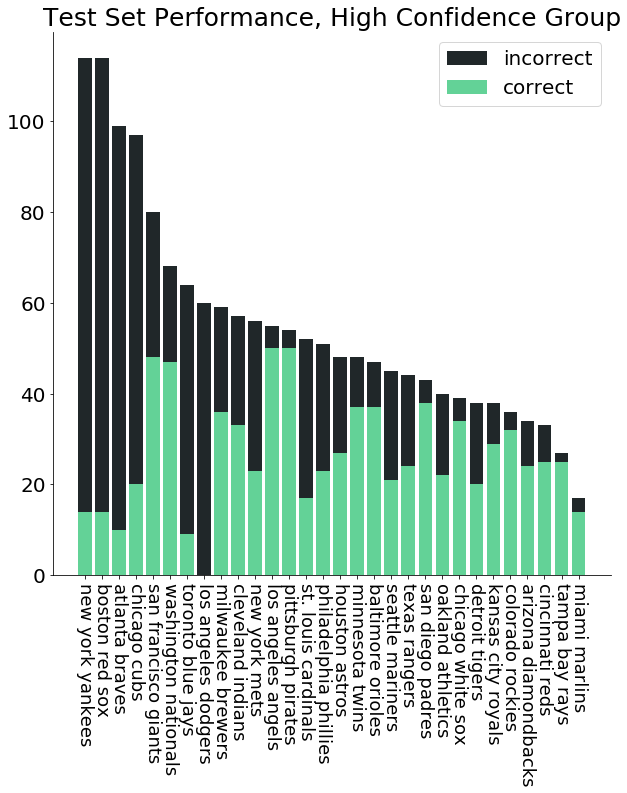

In [176]:
plt.figure(figsize=[10,10])
plt.bar([i[0] for i in totals], [i[1] for i in totals], label='incorrect', color='#202729')
plt.bar(correct_count.keys(), correct_count.values(), label='correct', color='#63d297')
plt.yticks(fontsize=20)
plt.xticks(rotation=-90, fontsize=18)
plt.legend(fontsize=20)
plt.title('Test Set Performance, High Confidence Group', fontsize=25)
sns.despine()

In [112]:
corrects = y_test == y_pred

In [81]:
for i in good_indices:
    print(i)
    print(dot.iloc[i,1])
    print(dot.iloc[i,3])

8098
new york mets
eternal flap grade meaningless lmao defense figure slow adjust aa dreadful productive monster vladdy gonna mediocre injured mets 500 likely shitshow oh anymore gave another mets drank planning committing suicide maine confirm beautiful state temporarily banned blue jay sub criticizing rogers greedy done stupid website need football fucking patriot else gonna mentally fucking explode royal confirmed playoff oriole giant take long course mets wilpons done rogers literally gifted beautiful farm system scared death fuck blue jay owner literally worst infuriating jay owned biggest give fuck organization hope 2019 jay completely different medical staff position coach getting kyle vibe srf reddit birthday count demote sean ugly tattoo 111 11 wtf tattoo hell jansen send martin every pull rough patch true jay giles save situation h declining quick trade prospect tulo rather bite bullet buy rest contract oh 50 considered alright 95 stupid correlation turned heroin enough count

In [82]:
dot.iloc[11721,:]

author                                                     itsmath
team                                             oakland athletics
tokens           [sack, accept, alternative, matt, chapman, top...
token_strings    sack accept alternative matt chapman top matt ...
Name: 11721, dtype: object

In [83]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from nltk import text

In [84]:
texts = dot['tokens']
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [85]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [86]:
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(list(dot['token_strings']))

In [87]:
lsa = TruncatedSVD(2, algorithm = 'randomized')
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [88]:
lsa.explained_variance_ratio_

array([0.32142997, 0.14073443])

In [89]:
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=40, update_every=1, chunksize=500, passes=5)

In [90]:
lda.print_topics(20)

NameError: name 'lda' is not defined

In [ ]:
my_bigrams = nltk.bigrams(dot['tokens'][1])

In [ ]:
alltokens = []
for tokens in dot['tokens']:
    alltokens += tokens

In [ ]:
text.Text(alltokens).collocations(200)

In [ ]:
type(dot['tokens'][1])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
wordcounts = dot['tokens'].apply(len)

In [ ]:
plt.hist(wordcounts, bins=[10*i for i in range(10)])

In [ ]:
len(wordcounts[wordcounts<10])/len(wordcounts)

In [ ]:
with open('dictionary.pkl', 'wb') as open_file:
    pkl.dump(dictionary, open_file)

In [ ]:
with open('corpus.pkl', 'wb') as open_file:
    pkl.dump(corpus, open_file)

In [ ]:
with open('ldamodel.pkl', 'wb') as open_file:
    pkl.dump(lda, open_file)

In [91]:
bad_users_examples = {9044, 11269,12358,12408}

In [93]:
bad_users_names = []
for i in bad_users_examples:
    bad_users_names.append(dot.iloc[i,0])

In [94]:
good_users_names = ['itsmath']
good_users_examples = {10487, 15039}
for i in good_users_examples:
    good_users_names.append(dot.iloc[i,0])

In [96]:
with open('badusers.pkl', 'wb') as open_file:
    pkl.dump(bad_users_names, open_file)
with open('goodusers.pkl', 'wb') as open_file:
    pkl.dump(good_users_names, open_file)